[View in Colaboratory](https://colab.research.google.com/github/evergou/TitanicML/blob/master/Processing_&_Modeling.ipynb)

# Processing the data

In [1]:
!git clone https://github.com/pair-code/facets.git

fatal: destination path 'facets' already exists and is not an empty directory.


In [2]:
!pip install numpy==1.14.5

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.display import display, HTML
from sklearn.metrics import recall_score, roc_auc_score, precision_score, accuracy_score, confusion_matrix, classification_report
pd.set_option("display.max_colwidth",100)
%matplotlib inline
SEED = 44

In [4]:
train = pd.read_csv(r"Data/train.csv", index_col = 0)
test = pd.read_csv(r"Data/test.csv", index_col = 0)

In [5]:
train.Cabin.fillna(0,inplace=True)
test.Cabin.fillna(0,inplace=True)
train["CabinCode"] = train.Cabin.apply(lambda x: str(x)[0])
test["CabinCode"] = test.Cabin.apply(lambda x: str(x)[0])

In [6]:
train.Age.fillna(train.Age.mean(),inplace=True)
train.Embarked.fillna(train.Embarked.mode()[0],inplace=True)
train["Sex"],a = train.Sex.factorize()
del(a)

In [7]:
train = train.join(train.groupby("Ticket").Survived.sum()>1, how="left", on="Ticket", rsuffix="_in_the_party")

In [8]:
#Display the Dive visualization for the training data.
from IPython.core.display import display, HTML

jsonstr = test.to_json(orient='records')
HTML_TEMPLATE = """<link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

In [9]:
train = pd.concat([train, pd.get_dummies(train["Embarked"], prefix="embark_")],1).drop(["Name","Ticket","Cabin","Embarked"],1)
train = pd.concat([train, pd.get_dummies(train["CabinCode"], prefix="cabin_")],1).drop("CabinCode",1)

In [10]:
#scaling the data
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
x_scaled = StandardScaler().fit_transform(train.drop("Survived",1))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, train.Survived, test_size=0.2, stratify = train.Survived, 
                                                    random_state = SEED)

In [12]:
X_train, X_test_cv, y_train, y_test_cv = train_test_split(X_train, y_train, test_size=0.2, stratify = y_train, 
                                                          random_state = SEED)

# LightGBM

In [13]:
!pip install lightgbm

In [14]:
import lightgbm as lgb
evals_result = {}
param = {'num_leaves':3, 'num_trees':12000, 'objective':'binary', "boosting":"dart",
         "learning_rate":0.001, "max_depth":3, "max_bin":50, "min_data_in_leaf":5,         
         "tree_learner":"feature", "verbose":1, "drop_rate":0.1, "xgboost_dart_mode": True, "predict_raw_score":True,
         "sigmoid" :1, "seed":SEED}
param['metric'] = 'auc'
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test_cv, y_test_cv, reference=train_data)

In [15]:
bst = lgb.train(param, train_data, evals_result = evals_result, verbose_eval = 1000,
               valid_sets = [train_data, test_data])

C:\Users\Home\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's auc: 0.88504	valid_1's auc: 0.837603
[2000]	training's auc: 0.900213	valid_1's auc: 0.866529
[3000]	training's auc: 0.903872	valid_1's auc: 0.876033
[4000]	training's auc: 0.903637	valid_1's auc: 0.874793
[5000]	training's auc: 0.911178	valid_1's auc: 0.872211
[6000]	training's auc: 0.913354	valid_1's auc: 0.871798
[7000]	training's auc: 0.917614	valid_1's auc: 0.873967
[8000]	training's auc: 0.919679	valid_1's auc: 0.873657
[9000]	training's auc: 0.920894	valid_1's auc: 0.877893
[10000]	training's auc: 0.921652	valid_1's auc: 0.883781
[11000]	training's auc: 0.923057	valid_1's auc: 0.883574
[12000]	training's auc: 0.924495	valid_1's auc: 0.878512


Plot metrics recorded during training...


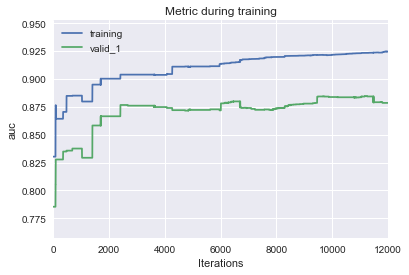

Feature importances: [2129, 5188, 522, 453, 730, 5144, 7210, 0, 201, 294, 1181, 253, 587, 0, 108, 0, 0, 0, 0]


In [16]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

print('Feature importances:', list(bst.feature_importance()))

In [17]:
prediction = bst.predict(X_test, num_iteration=bst.best_iteration)

In [18]:
pred = np.zeros(len(prediction))
pred[prediction>0.4]=1

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.8100558659217877

# Other Models

In [20]:
from __future__ import print_function
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
np.random.seed(SEED)

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True, random_state=SEED)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED, warm_start= "True")
    nn = MLPClassifier((10,10,10,10), learning_rate_init = 0.01,
                       learning_rate = "adaptive", max_iter = 600,
                       early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    sgdb = SGDClassifier(loss="log", random_state=SEED)    
    bagging = BaggingClassifier(gb, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)
    ada = AdaBoostClassifier(base_estimator = gb, n_estimators = 50, random_state=SEED)
    models = {
             'knn': knn,
             'naive bayes': nb,
             "svc": svc,
             'mlp-nn': nn,
             'random forest': rf,
             'gbm': gb,
             "bag" : bagging,
             "sgdb" : sgdb,
             'logistic': lr,
             'ada': ada              
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ")
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict(X_test)
        #[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = accuracy_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")
    

In [21]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models.
knn... done
naive bayes... done
svc... done
mlp-nn... done
random forest... done
gbm... done
bag... done
sgdb... done
logistic... done
ada... done
Done.

Scoring models.
knn                       : 0.737
naive bayes               : 0.698
svc                       : 0.810
mlp-nn                    : 0.799
random forest             : 0.771
gbm                       : 0.804
bag                       : 0.793
sgdb                      : 0.682
logistic                  : 0.810
ada                       : 0.771
Done.



# DNN

In [22]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
np.random.seed(SEED)

C:\Users\Home\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['acc']), 
           label='Train Accuracy')
  plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Accuracy')
  plt.legend()
  plt.ylim([0.6,0.950])

In [24]:
rate = 0.1

model = keras.Sequential([keras.layers.Dense(10, input_dim = X_train.shape[1], activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=SEED),
                          keras.layers.Dense(10, activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=SEED),
                          keras.layers.Dense(10, activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=SEED),
                          keras.layers.Dense(10, activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=SEED),
                          keras.layers.Dense(10, activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=SEED),
                          keras.layers.Dense(10, activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=SEED),
                          keras.layers.Dense(1, activation="sigmoid")    
])

In [26]:
model.compile(optimizer= tf.train.GradientDescentOptimizer(learning_rate = 0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, train.Survived, test_size=0.2, stratify = train.Survived,
                                                   random_state=SEED)

In [29]:
history = model.fit(X_train, y_train, epochs=1200, verbose=0, validation_split=0.2,shuffle=0)

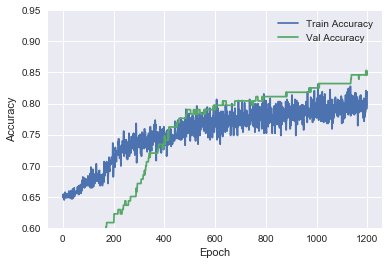

In [30]:
plot_history(history)